# SVMs classifier 

Links to papers and related information:

https://www.academia.edu/105567508/Design_of_Automatic_Number_Plate_Recognition_System_for_Yemeni_Vehicles_with_Support_Vector_Machine?nav_from=589832a2-802f-4a39-88b6-e15bc16559e1

https://www.academia.edu/73123341/Saudi_License_Plate_Recognition_Algorithm_Based_on_Support_Vector_Machine?nav_from=4994dbac-b96a-4746-ac91-52791c1b17b3

https://www.academia.edu/110187161/SVM_Based_License_Plate_Recognition_System?nav_from=36dcd588-c2c0-48f5-bf6c-6a6e18d1b73d

https://github.com/ashutoshsuman99/License-Plate-Recognition-System/blob/master/model_creation.py


One-vs-one

One-vs-many

## Part III: Plate Recognition using SVM

### Libraries

In [84]:
from sklearn import svm
import joblib
import os
from sklearn.svm import SVC
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


### Creation of the datasets

Function to obtain our dataset of the folder SVMs

In [85]:
ALLOWED_LETTERS = 'BCDFGHJKLMNPRSTVWXYZ'
DIGITS = '0123456789'

# Function to load images and labels
def load_data(folder_path, classes):
    train_data = []  # List to store feature vectors (flattened images)
    train_labels = []  # List to store labels (corresponding letters/numbers)
    
    for class_name in classes:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            if filename.endswith(".jpg"):
                img_path = os.path.join(class_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
                img = cv2.resize(img, (20, 20))
                img_flattened = img.flatten()  # Flatten image to 1D vector
                train_data.append(img_flattened)
                train_labels.append(class_name)  # Append the label (class name)
    
    return np.array(train_data), np.array(train_labels)

Obtaining the training data of the digits

In [86]:
# Paths to the digit and letter folders
digit_folder_path = "SVMs/Digits"

# Load digit data
X_digits, y_digits = load_data(digit_folder_path, DIGITS)


Obtaining the training data of the letters

In [87]:
letter_folder_path = "SVMs/Letters"

# Load letter data
X_letters, y_letters = load_data(letter_folder_path, ALLOWED_LETTERS)


In [88]:
# Printing some information about the datasets

print(f' DIGITS DATASET')
print(f'Training data shape: {X_digits.shape}')
print(f"Number of unique classes: {len(np.unique(y_digits))}")
print(f"Classes: {np.unique(y_digits)}")



print(f'\n LETTERS DATASET')
print(f'Training data shape: {X_letters.shape}')
print(f"Number of unique classes: {len(np.unique(y_letters))}")
print(f"Classes: {np.unique(y_letters)}")

 DIGITS DATASET
Training data shape: (10300, 400)
Number of unique classes: 10
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']

 LETTERS DATASET
Training data shape: (20150, 400)
Number of unique classes: 20
Classes: ['B' 'C' 'D' 'F' 'G' 'H' 'J' 'K' 'L' 'M' 'N' 'P' 'R' 'S' 'T' 'V' 'W' 'X'
 'Y' 'Z']


Saving all training data

In [89]:
# Saving the numbers training data
models_folder = "SVMs/datasets"
file_x_digits = 'train_data_digits.pkl'
file_y_digits = 'train_labels_digits.pkl'

#save the training data and labels
digit_path_x = os.path.join(models_folder, file_x_digits)
joblib.dump(X_digits, digit_path_x)
print(f'Training data saved to {digit_path_x}')

digit_path_y = os.path.join(models_folder, file_y_digits)
joblib.dump(y_digits, digit_path_y)
print(f'Training labels saved to {digit_path_y}')



# Saving the letters training data
file_x_letters = 'train_data_letters.pkl'
file_y_letters = 'train_labels_letters.pkl'

#save the training data and labels
letter_path_x = os.path.join(models_folder, file_x_letters)
joblib.dump(X_letters, letter_path_x)
print(f'Training data saved to {letter_path_x}')

letter_path_y = os.path.join(models_folder, file_y_letters)
joblib.dump(y_letters, letter_path_y)
print(f'Training labels saved to {letter_path_y}')

Training data saved to SVMs/datasets\train_data_digits.pkl
Training labels saved to SVMs/datasets\train_labels_digits.pkl
Training data saved to SVMs/datasets\train_data_letters.pkl
Training labels saved to SVMs/datasets\train_labels_letters.pkl


### Creation of the SVMs models

In [90]:
#  Train SVM for digits
svm_digits = SVC(kernel='linear', C=50)
svm_digits.fit(X_digits, y_digits)


# Train SVM for letters
svm_letters = SVC(kernel='linear', C=50)
svm_letters.fit(X_letters, y_letters)

SVC(C=50, kernel='linear')

### Prediction functions

In [91]:
#function to visualize the full plate prediction with the ground truth
def visualize_full_plate(plate_image_path, predicted_plate, actual_plate):
    img = cv2.imread(plate_image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Could not load the image at {plate_image_path}")
    
    # Display the plate image along with ground truth and predicted plate
    plt.imshow(img, cmap='gray')
    plt.title(f'Ground Truth: {actual_plate}\nPredicted: {predicted_plate}')
    plt.axis('off')
    plt.show()

# preprocessing the image for the SVM
def preprocess_image_svm(image_path):
    char_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    char_image = cv2.resize(char_image, (20, 20))  # Resize to match the training size
    char_image_flattened = char_image.flatten()
    return char_image_flattened

In [92]:


# Predict characters from a segmented license plate
def recognize_characters(plate_folder_path, svm_numbers, svm_letters):
    recognized_plate = []

    for idx in range(1, 8):  #assuming 7 blobs (blob_1 to blob_7)
        blob_filename = f'blob_{idx}.jpg'
        blob_path = os.path.join(plate_folder_path, blob_filename)
        if os.path.exists(blob_path):   
            char_image = preprocess_image_svm(blob_path) 
            if idx < 5:  # First 4 characters should be digits
                predicted_char = svm_numbers.predict([char_image])[0]
            else:  # The last 3 characters should be letters
                predicted_char = svm_letters.predict([char_image])[0]
            
            recognized_plate.append(predicted_char)

    return ''.join(recognized_plate)


In [93]:
def process_all_plates(plate_digits_folder, plate_images_folder, svm_digits, svm_letters):
    correct_predictions_char = 0
    correct_predictions_plates = 0
    total_characters = 0
    total_plates = 0
    
    #traverse the 'frontal' and 'lateral' folders inside 'PlateDigits'
    for plate_type in ['frontal', 'lateral']:
        plate_type_folder = os.path.join(plate_digits_folder, plate_type)
        
        #iterate through each license plate folder inside 'frontal' or 'lateral'
        for root, dirs, _ in os.walk(plate_type_folder):
            for dir_name in dirs:
                plate_folder_path = os.path.join(root, dir_name)
                
                #the actual plate number is derived from the folder name, removing the '.jpg' extension
                actual_plate = dir_name.replace('.jpg', '')  # Remove '.jpg'
                
                #predict the full plate by processing the 7 blobs
                predicted_plate = recognize_characters(plate_folder_path, svm_digits, svm_letters)
                
                #now search in PlateImages based on the 'plate_type' (frontal or lateral)
                plate_image_path_jpg = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.jpg')
                plate_image_path_png = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.png')

                #visualize the prediction with the plate image if it exists
                if os.path.exists(plate_image_path_jpg):
                    visualize_full_plate(plate_image_path_jpg, predicted_plate, actual_plate)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                elif os.path.exists(plate_image_path_png):
                    visualize_full_plate(plate_image_path_png, predicted_plate, actual_plate)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                else:
                    print(f"Warning: Plate image for {actual_plate} in {plate_type.capitalize()} does not exist.")

                #update total characters and correct predictions
                total_characters += len(actual_plate)  # Add the number of characters in the actual plate
                correct_predictions_char += sum(1 for i in range(min(len(actual_plate), len(predicted_plate))) 
                                            if actual_plate[i] == predicted_plate[i])  # Count correct characters
                # Update total plates and correct plate predictions
                total_plates += 1  # Count total number of plates processed
                if actual_plate == predicted_plate:  # Compare entire plate
                    correct_predictions_plates += 1
    
    #compute and print accuracy based on individual characters
    if total_characters > 0:
        accuracy = (correct_predictions_char / total_characters) * 100
        print(f"\nCharacter-Level Accuracy: {accuracy:.2f}% ({correct_predictions_char} correct out of {total_characters})")
    # Compute and print plate-level accuracy
    if total_plates > 0:
        plate_accuracy = (correct_predictions_plates / total_plates) * 100
        print(f"\nPlate-Level Accuracy: {plate_accuracy:.2f}% ({correct_predictions_plates} correct out of {total_plates} plates)")
    else:
        print("No characters were processed.")

### Testing

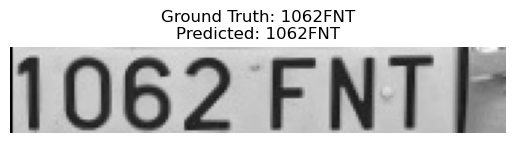

Processed Plate: 1062FNT (frontal) | Predicted: 1062FNT


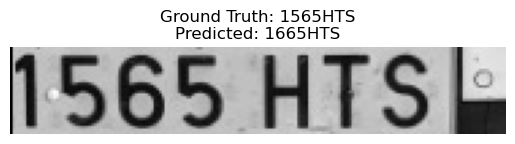

Processed Plate: 1565HTS (frontal) | Predicted: 1665HTS


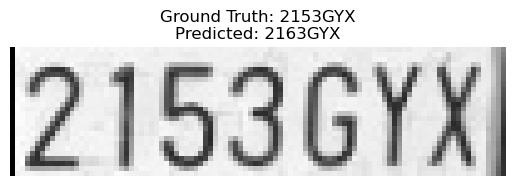

Processed Plate: 2153GYX (frontal) | Predicted: 2163GYX


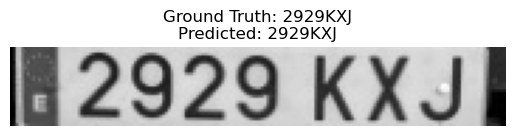

Processed Plate: 2929KXJ (frontal) | Predicted: 2929KXJ


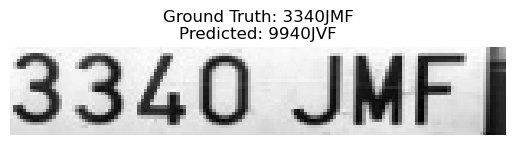

Processed Plate: 3340JMF (frontal) | Predicted: 9940JVF


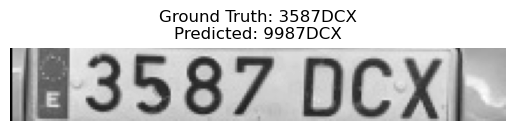

Processed Plate: 3587DCX (frontal) | Predicted: 9987DCX


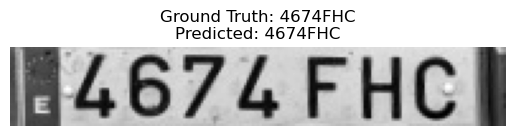

Processed Plate: 4674FHC (frontal) | Predicted: 4674FHC


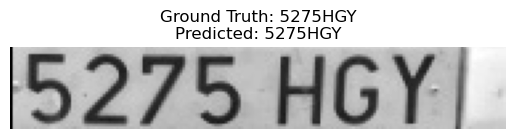

Processed Plate: 5275HGY (frontal) | Predicted: 5275HGY


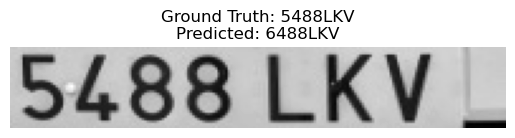

Processed Plate: 5488LKV (frontal) | Predicted: 6488LKV


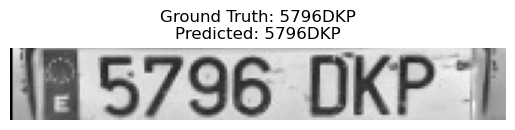

Processed Plate: 5796DKP (frontal) | Predicted: 5796DKP


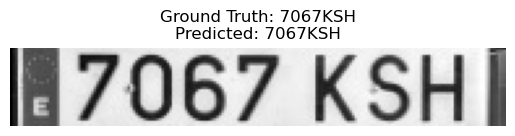

Processed Plate: 7067KSH (frontal) | Predicted: 7067KSH


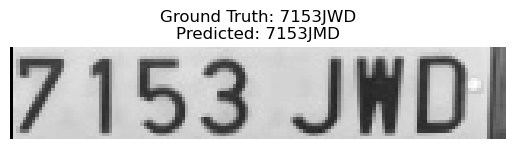

Processed Plate: 7153JWD (frontal) | Predicted: 7153JMD


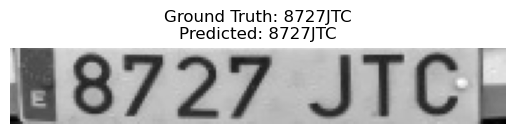

Processed Plate: 8727JTC (frontal) | Predicted: 8727JTC


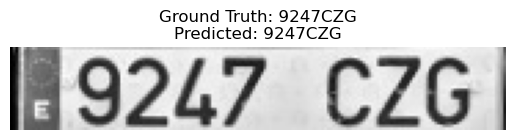

Processed Plate: 9247CZG (frontal) | Predicted: 9247CZG


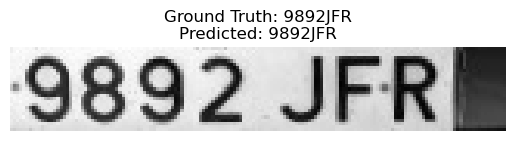

Processed Plate: 9892JFR (frontal) | Predicted: 9892JFR


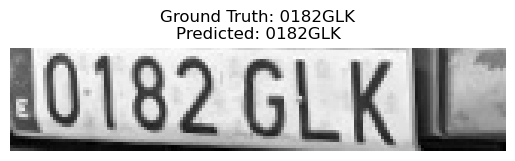

Processed Plate: 0182GLK (lateral) | Predicted: 0182GLK


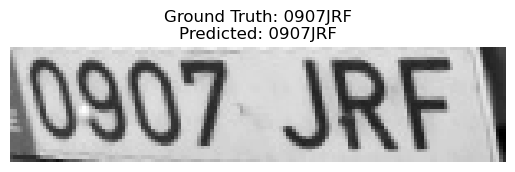

Processed Plate: 0907JRF (lateral) | Predicted: 0907JRF


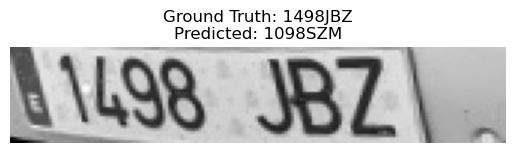

Processed Plate: 1498JBZ (lateral) | Predicted: 1098SZM


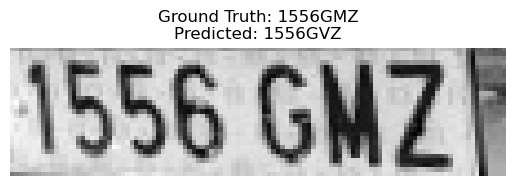

Processed Plate: 1556GMZ (lateral) | Predicted: 1556GVZ


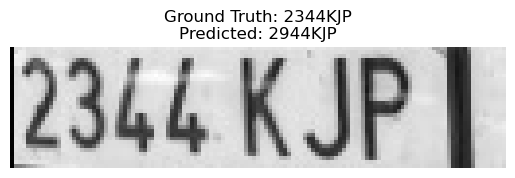

Processed Plate: 2344KJP (lateral) | Predicted: 2944KJP


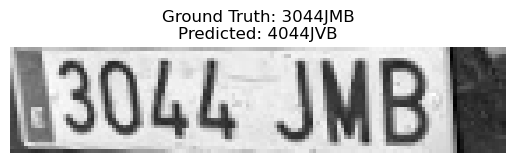

Processed Plate: 3044JMB (lateral) | Predicted: 4044JVB


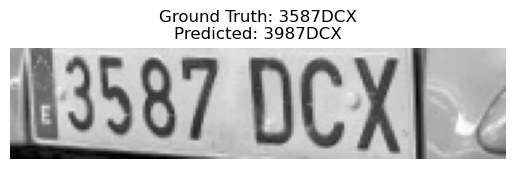

Processed Plate: 3587DCX (lateral) | Predicted: 3987DCX


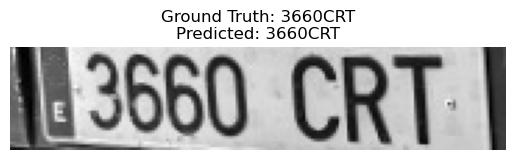

Processed Plate: 3660CRT (lateral) | Predicted: 3660CRT


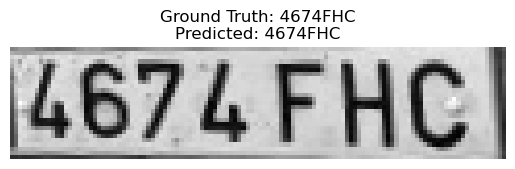

Processed Plate: 4674FHC (lateral) | Predicted: 4674FHC


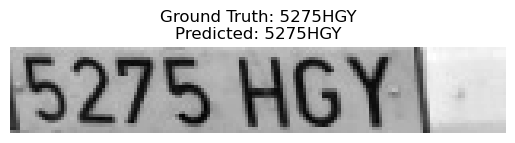

Processed Plate: 5275HGY (lateral) | Predicted: 5275HGY


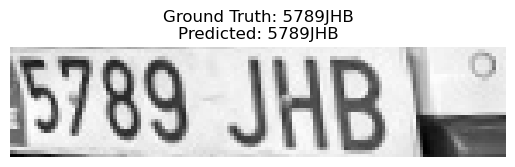

Processed Plate: 5789JHB (lateral) | Predicted: 5789JHB


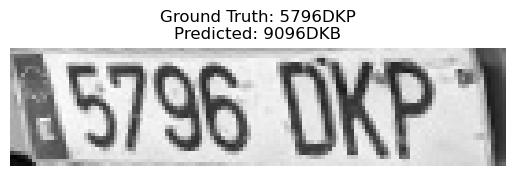

Processed Plate: 5796DKP (lateral) | Predicted: 9096DKB


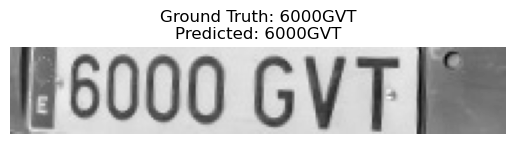

Processed Plate: 6000GVT (lateral) | Predicted: 6000GVT


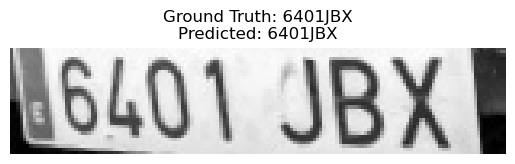

Processed Plate: 6401JBX (lateral) | Predicted: 6401JBX


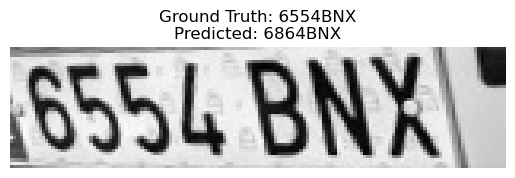

Processed Plate: 6554BNX (lateral) | Predicted: 6864BNX


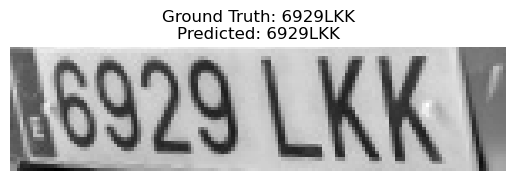

Processed Plate: 6929LKK (lateral) | Predicted: 6929LKK


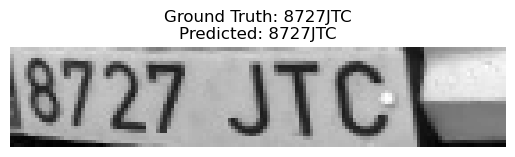

Processed Plate: 8727JTC (lateral) | Predicted: 8727JTC

Character-Level Accuracy: 89.73% (201 correct out of 224)

Plate-Level Accuracy: 59.38% (19 correct out of 32 plates)


In [94]:
plate_digits_folder = 'PlateDigits'  # Contains 'frontal' and 'lateral' with blobs
plate_images_folder = 'PlateImages'  # Contains full plate images

#run the function to process and visualize all plates and compute accuracy
process_all_plates(plate_digits_folder, plate_images_folder, svm_digits, svm_letters)

SVC LINEAR AND C=1.0
Char - 89.73%
Plate - 59.38%

SVC LINEAR AND C=10
Char - 89.73%
Plate - 59.38%

SVC LINEAR AND C=50

